In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection


In [2]:
# Define transformations
class CocoTransform:
    def __call__(self, image, target):
        image = F.to_tensor(image)                       # Convert PIL image to tensor
        return image, target


In [24]:
# Dataset class
def get_coco_dataset(img_dir, ann_file):
    return CocoDetection(
        root=img_dir,
        annFile=ann_file,
        transforms=CocoTransform()
    )

# Load datasets
train_dataset = get_coco_dataset(
    img_dir="C:/Users/HP/Desktop/Data/train",
    ann_file="C:/Users/HP/Desktop/Data/annotations_split/train.json"
)


val_dataset = get_coco_dataset(
    img_dir="C:/Users/HP/Desktop/Data/val",
    ann_file="C:/Users/HP/Desktop/Data/annotations_split/val.json"
)
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


loading annotations into memory...
Done (t=0.24s)
creating index...
index created!
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [25]:
# Load Faster R-CNN with ResNet-50 backbone
def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [26]:
# Initialize the model
num_classes = 8 # Background + person,build,etc
model = get_model(num_classes)

In [27]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [32]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    for images, targets in data_loader:
        # Move images to the device
        images = [img.to(device) for img in images]

        # Validate and process targets
        processed_targets = []
        valid_images = []
        for i, target in enumerate(targets):
            boxes = []
            labels = []
            for obj in target:
                # Extract bbox
                bbox = obj["bbox"]  # Format: [x, y, width, height]
                x, y, w, h = bbox

                # Ensure the width and height are positive
                if w > 0 and h > 0:
                    boxes.append([x, y, x + w, y + h])  # Convert to [x_min, y_min, x_max, y_max]
                    labels.append(obj["category_id"])

            # Only process if there are valid boxes
            if boxes:
                processed_target = {
                    "boxes": torch.tensor(boxes, dtype=torch.float32).to(device),
                    "labels": torch.tensor(labels, dtype=torch.int64).to(device),
                }
                processed_targets.append(processed_target)
                valid_images.append(images[i])  # Add only valid images

        # Skip iteration if no valid targets
        if not processed_targets:
            continue
        # Ensure images and targets are aligned
        images = valid_images
        # Forward pass
        loss_dict = model(images, processed_targets)
        losses = sum(loss for loss in loss_dict.values())
        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    print(f"Epoch [{epoch}] Loss: {losses.item():.4f}")


In [36]:
# Training loop
num_epochs = 7
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()

    # Save the model's state dictionary after every epoch
    model_path = f"fasterrcnn_resnet50_epoch_{epoch + 1}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved: {model_path}")


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/HP/Desktop/Data/train\\34_670020_135_490599_180_jpg.rf.a2424644f7f40d6c0153d012999d97b2.jpg'

C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Processing: C:/Users/HP/Desktop/TT\51_438684_-2_611106_0_jpg.rf.f2c134bb38f1bb2bc0ae197387d54b50.jpg


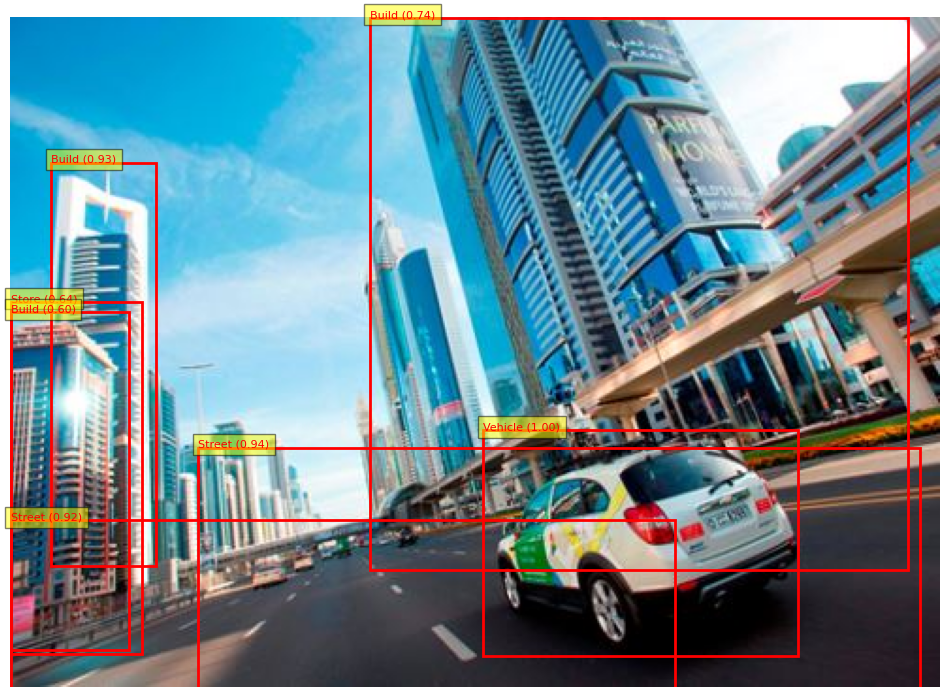

In [1]:
import os
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image

# Load Faster R-CNN with ResNet-50 backbone
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Initialize the model
num_classes = 7
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load the trained model
model = get_model(num_classes)
model.load_state_dict(torch.load("26April7.pth", map_location=device))
model.to(device)
model.eval()

def prepare_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image).unsqueeze(0)
    return image_tensor.to(device)

COCO_CLASSES = {0: "Objects", 1: "Build", 2: "Person", 3: "Sign", 4: "Store", 5: "Street", 6: "Vegetation", 7: "Vehicle"}

def get_class_name(class_id):
    return COCO_CLASSES.get(class_id, "Unknown")

def draw_boxes(image, prediction, fig_size=(10, 10)):
    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()
    threshold = 0.5
    plt.figure(figsize=fig_size)
    plt.imshow(image)
    ax = plt.gca()
    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            x_min, y_min, x_max, y_max = box
            class_name = get_class_name(label)
            ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                       linewidth=2, edgecolor='r', facecolor='none'))
            ax.text(x_min, y_min, f"{class_name} ({score:.2f})", color='red', fontsize=8,
                    bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()
# New part: Loop over all images in a folder
def process_folder(folder_path):
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

    for filename in os.listdir(folder_path):
        if any(filename.lower().endswith(ext) for ext in image_extensions):
            image_path = os.path.join(folder_path, filename)
            print(f"Processing: {image_path}")
            image = Image.open(image_path).convert("RGB")
            image_tensor = prepare_image(image_path)

            with torch.no_grad():
                prediction = model(image_tensor)

            draw_boxes(image, prediction, fig_size=(12, 10))
# Usage:
folder_path = "C:/Users/HP/Desktop/TT"
process_folder(folder_path)
